# Replicate Vanderburg & Johnson 2014 K2SFF Method

In this notebook we will replicate the K2SFF method from [Vanderburg and Johnson 2014](http://adsabs.harvard.edu/abs/2014PASP..126..948V).  The paper introduces a method for "Self Flat Fielding", by tracking how the lightcurve changes with motion of the spacecraft.

In [1]:
from pyke import KeplerTargetPixelFile
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#from oktopus import UniformPrior, JointPrior
#from pyke import PRFPhotometry, SceneModel
#from pyke.utils import KeplerQualityFlags

## Get data

In [3]:
#! wget https://www.cfa.harvard.edu/~avanderb/k2/ep60021426alldiagnostics.csv

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('ep60021426alldiagnostics.csv',index_col=False)

In [6]:
df.head()

,BJD - 2454833,Raw Flux,Corrected Flux,X-centroid,Y-centroid,arclength,Correction,Thrusters On
0,1862.502368,0.995119,0.995985,25.135097,24.661074,2.327480,0.999130,1.0
1,1862.522801,0.997313,0.996767,25.289752,24.418689,1.175322,1.000548,1.0
2,1862.543235,0.996713,0.996136,25.288052,24.429406,1.214627,1.000580,0.0
3,1862.563668,0.996930,0.996277,25.275216,24.448405,1.306617,1.000656,0.0
4,1862.584102,0.996862,0.996228,25.253864,24.480184,1.460259,1.000636,0.0


Let's use the provided $x-y$ centroids, but we could compute these on our own too.

In [7]:
col = df[' X-centroid'].values
col = col - np.mean(col)
row = df[' Y-centroid'].values 
row = row - np.mean(row)

In [8]:
def _get_eigen_vectors(centroid_col, centroid_row):
    centroids = np.array([centroid_col, centroid_row])
    eig_val, eig_vec = np.linalg.eigh(np.cov(centroids))
    return eig_val, eig_vec

In [9]:
def _rotate(eig_vec, centroid_col, centroid_row):
    centroids = np.array([centroid_col, centroid_row])
    return np.dot(eig_vec, centroids)

In [10]:
eig_val, eig_vec = _get_eigen_vectors(col, row)

In [11]:
v1, v2 = eig_vec

The major axis is the last one.

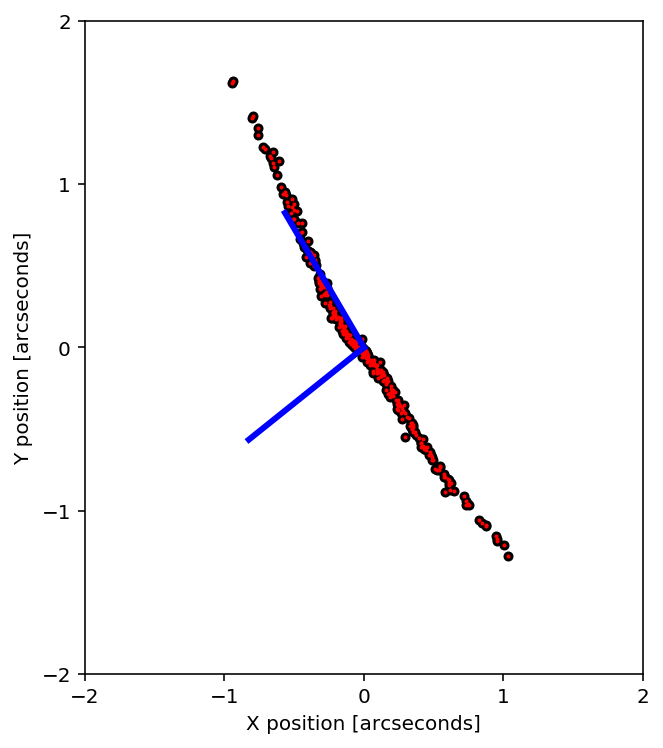

In [12]:
plt.figure(figsize=(5, 6))
plt.plot(col*4.0, row*4.0, 'ko', ms=4)
plt.plot(col*4.0, row*4.0, 'ro', ms=1)
plt.xticks([-2, -1,0, 1, 2])
plt.yticks([-2, -1,0, 1, 2])
plt.xlabel('X position [arcseconds]')
plt.ylabel('Y position [arcseconds]')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot([0, v1[0]], [0, v1[1]], color='blue', lw=3)
plt.plot([0, v2[0]], [0, v2[1]], color='blue', lw=3);

Following the form of Figure 2 of Vanderburg & Johsnon 2014.

In [13]:
rot_colp, rot_rowp = _rotate(eig_vec, col, row)

You can rotate into the new reference frame.

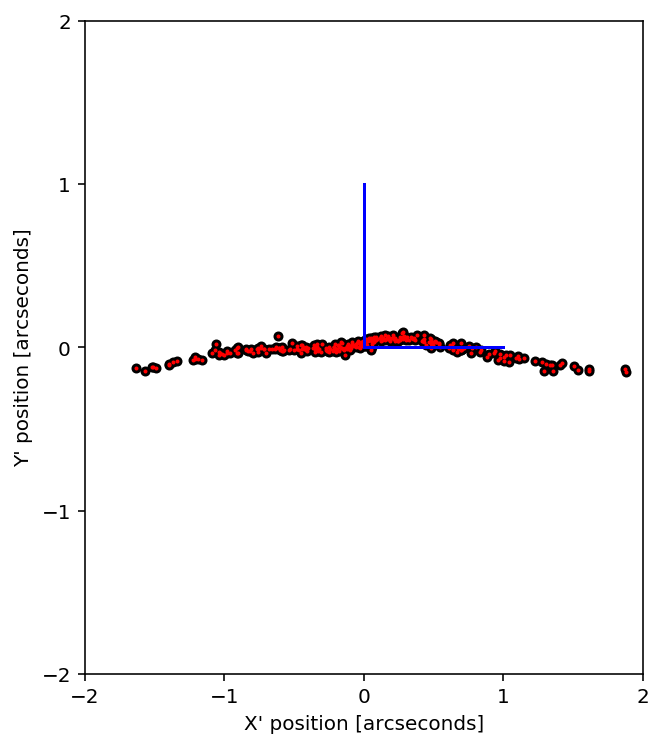

In [14]:
plt.figure(figsize=(5, 6))
plt.plot(rot_rowp*4.0, rot_colp*4.0, 'ko', ms=4)
plt.plot(rot_rowp*4.0, rot_colp*4.0, 'ro', ms=1)
plt.xticks([-2, -1,0, 1, 2])
plt.yticks([-2, -1,0, 1, 2])
plt.xlabel("X' position [arcseconds]")
plt.ylabel("Y' position [arcseconds]")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot([0, 1], [0, 0], color='blue')
plt.plot([0, 0], [0, 1], color='blue');

We need to calculate the arclength using:
$$s= \int_{x'_0}^{x'_1}\sqrt{1+\left( \frac{dy'_p}{dx'}\right)^2} dx'$$

> where $x^\prime_0$ is the transformed $x$ coordinate of the point with the smallest $x^\prime$ position, and $y^\prime_p$ is the best--fit polynomial function.

In [15]:
z = np.polyfit(rot_rowp, rot_colp, 5)
p5 = np.poly1d(z)
p5_deriv = p5.deriv()

In [16]:
x0_prime = np.min(rot_rowp)
xmax_prime = np.max(rot_rowp)

In [17]:
x_dense = np.linspace(x0_prime, xmax_prime, 2000)

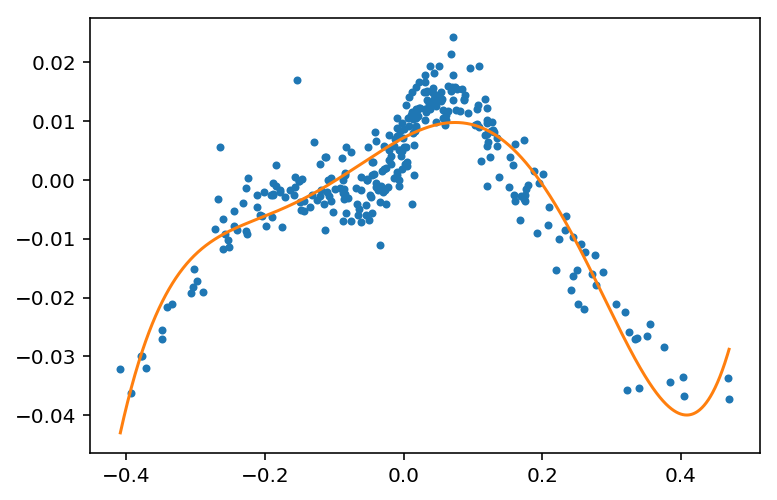

In [18]:
plt.plot(rot_rowp, rot_colp, '.')
plt.plot(x_dense, p5(x_dense));

In [19]:
@np.vectorize
def arclength(x):
    '''Input x1_prime, get out arclength'''
    gi = x_dense <x
    s_integrand = np.sqrt(1 + p5_deriv(x_dense[gi]) ** 2)
    s = np.trapz(s_integrand, x=x_dense[gi])
    return s

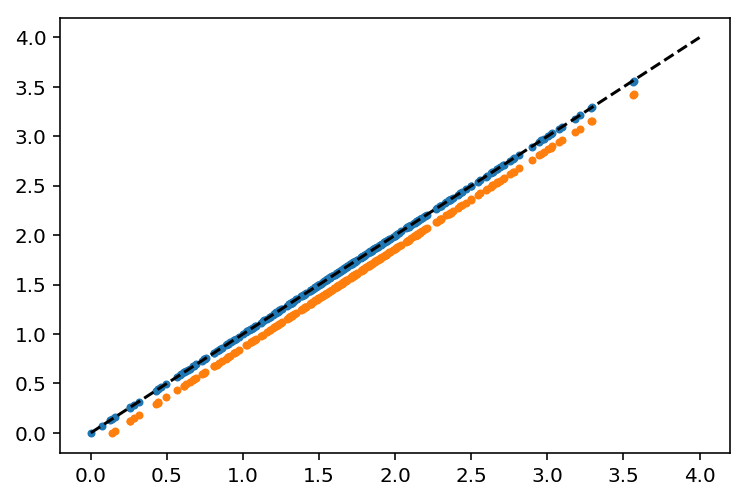

In [54]:
plt.plot(df[' arclength'], arclength(rot_rowp)*4.0, '.')
plt.plot(df[' arclength'][gi], sff.s*4.0, '.')
plt.plot([0, 4], [0, 4], 'k--');

In [56]:
sff.s*4.0 - df[' arclength'][gi]

2     -0.136129
3     -0.136379
4     -0.136032
5     -0.136373
8     -0.136985
9     -0.136331
10    -0.136249
11    -0.136160
12    -0.136273
13    -0.136375
14    -0.136220
15    -0.136298
16    -0.136218
17    -0.136142
18    -0.136299
19    -0.136128
20    -0.136246
21    -0.136426
22    -0.136321
25    -0.136540
26    -0.136376
27    -0.136295
28    -0.136397
29    -0.136379
30    -0.136318
31    -0.136378
32    -0.135942
33    -0.136259
34    -0.136417
35    -0.136263
         ...   
275   -0.136357
276   -0.136183
277   -0.136249
278   -0.136366
279   -0.136494
280   -0.136223
281   -0.136508
282   -0.136426
284   -0.136105
285   -0.136221
286   -0.136426
287   -0.136455
288   -0.136399
289   -0.136437
290   -0.136409
291   -0.135980
292   -0.136075
293   -0.136549
294   -0.136155
296   -0.136424
297   -0.136176
298   -0.136415
299   -0.136364
300   -0.136216
301   -0.136353
302   -0.136462
303   -0.136473
304   -0.136515
305   -0.136059
306   -0.136577
Name:  arclength, Length

In [21]:
arclength(rot_rowp)*4.0 - df[' arclength']

0     -0.000293
1     -0.001636
2     -0.000426
3     -0.000790
4     -0.001093
5     -0.001244
6     -0.001318
7     -0.001126
8     -0.001093
9     -0.001275
10    -0.000204
11    -0.000474
12    -0.000731
13    -0.000496
14    -0.000959
15    -0.000968
16    -0.000176
17    -0.000408
18    -0.000453
19    -0.000608
20    -0.001802
21    -0.000223
22    -0.000916
23    -0.001148
24    -0.000800
25    -0.000469
26    -0.000729
27    -0.000797
28    -0.000689
29    -0.000703
         ...   
277   -0.000378
278   -0.000662
279   -0.001666
280   -0.000375
281   -0.000454
282   -0.001930
283   -0.001409
284   -0.001263
285   -0.000597
286   -0.001467
287   -0.000354
288   -0.000392
289   -0.000207
290   -0.000325
291   -0.001894
292   -0.001629
293   -0.001748
294   -0.001568
295   -0.001130
296   -0.000884
297   -0.000127
298   -0.000015
299   -0.001015
300   -0.000822
301   -0.001574
302   -0.000896
303   -0.000690
304   -0.000329
305   -0.000992
306   -0.000790
Name:  arclength, Length

It works!

Now we apply a high-pass filter.  We follow the original paper by using BSplines with 1.5 day breakpoints.

In [22]:
from scipy.interpolate import BSpline
from scipy import interpolate

In [23]:
tt, ff = df['BJD - 2454833'].values, df[' Raw Flux'].values
tt = tt - tt[0]

In [24]:
knots = np.arange(0, tt[-1], 1.5)

In [25]:
t,c,k = interpolate.splrep(tt, ff, s=0, task=-1, t=knots[1:])

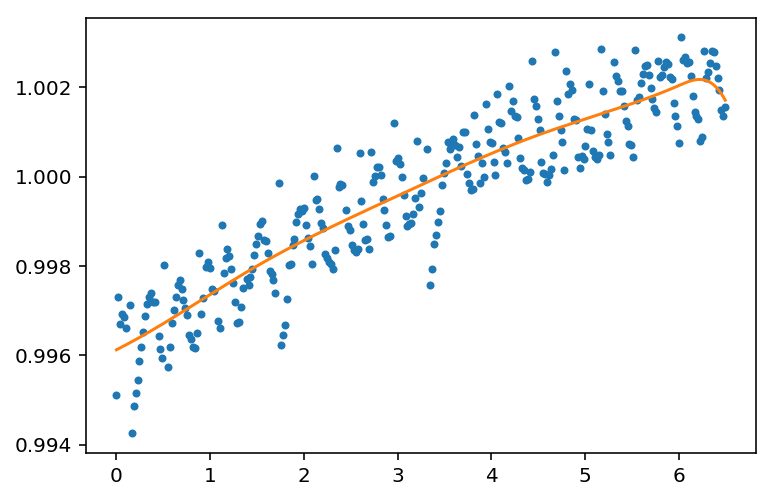

In [26]:
bspl = BSpline(t,c,k)

plt.plot(tt, ff, '.')
plt.plot(tt, bspl(tt))

Spline fit looks good, so normalize the flux by the long-term trend.  
Plot the normalized flux versus arclength to see the position-dependent flux.

In [27]:
norm_ff = ff/bspl(tt)

Mask the data by keeping only the good samples.

In [28]:
bi = df[' Thrusters On'].values == 1.0
gi = df[' Thrusters On'].values == 0.0
al, gff = arclength(rot_rowp[gi])*4.0, norm_ff[gi]

In [29]:
sorted_inds = np.argsort(al)

We will follow the paper by interpolating 15 bins of means.  This is a piecewise linear fit.

In [30]:
knots = np.array([np.min(al)]+ 
                 [np.median(splt) for splt in np.array_split(al[sorted_inds], 15)]+
                 [np.max(al)])

In [31]:
bin_means = np.array([gff[sorted_inds][0]]+
                     [np.mean(splt) for splt in np.array_split(gff[sorted_inds], 15)]+
                     [gff[sorted_inds][-1]])

In [32]:
zz = np.polyfit(al, gff,6)
sff = np.poly1d(zz)
al_dense = np.linspace(0, 4, 1000)
interp_func = interpolate.interp1d(knots, bin_means)

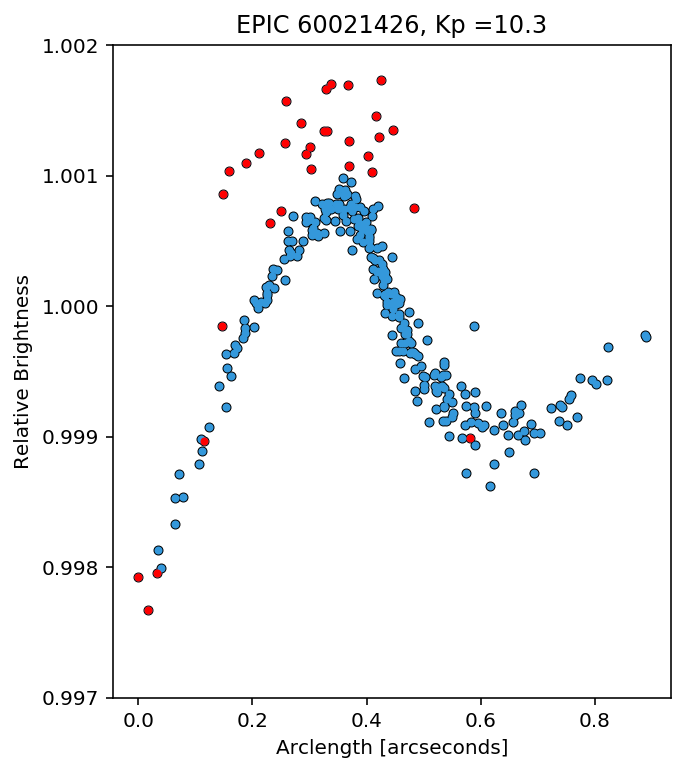

In [33]:
plt.figure(figsize=(5, 6))
plt.plot(arclength(rot_rowp), norm_ff, 'ko', ms=4)
plt.plot(arclength(rot_rowp), norm_ff, 'o', color='#3498db', ms=3)
plt.plot(arclength(rot_rowp[bi]), norm_ff[bi], 'o', color='r', ms=3)
#plt.plot(al_dense, sff(al_dense), '-', color='#e67e22')
#plt.plot(knots, bin_means, '-', color='#e67e22')
#plt.plot(np.sort(al), interp_func(np.sort(al)), '-', color='#e67e22')

#plt.xticks([0, 1,2, 3, 4])
plt.xlabel('Arclength [arcseconds]')
plt.ylabel('Relative Brightness')
plt.title('EPIC 60021426, Kp =10.3')
#plt.xlim(0,4)
plt.ylim(0.997, 1.002);

Following Figure 4 of Vanderburg & Johnson 2014.

Apply the Self Flat Field (SFF) correction:

In [34]:
corr_flux = gff / interp_func(al)

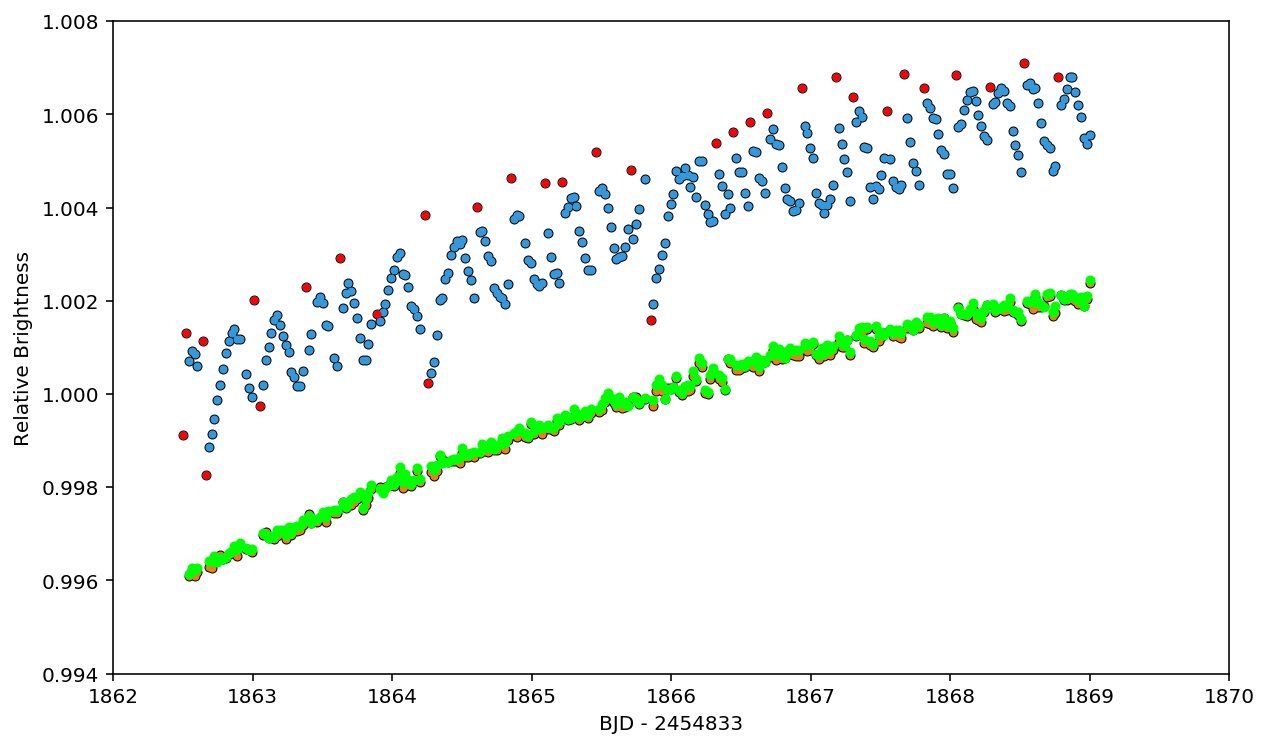

In [48]:
plt.figure(figsize=(10,6))

dy = 0.004
plt.plot(df['BJD - 2454833'], df[' Raw Flux']+dy, 'ko', ms=4)
plt.plot(df['BJD - 2454833'], df[' Raw Flux']+dy, 'o', color='#3498db', ms=3)
plt.plot(df['BJD - 2454833'][bi], df[' Raw Flux'][bi]+dy, 'o', color='r', ms=3)



plt.plot(df['BJD - 2454833'][gi], corr_flux*bspl(tt[gi]), 'o', color='k', ms = 4)
plt.plot(df['BJD - 2454833'][gi], corr_flux*bspl(tt[gi]), 'o', color='#e67e22', ms = 3)

plt.plot(df['BJD - 2454833'][gi], df[' Corrected Flux'][gi], 'o', color='#00ff00', ms = 4)

plt.xlabel('BJD - 2454833')
plt.ylabel('Relative Brightness')

plt.xlim(1862, 1870)
plt.ylim(0.994, 1.008);

Following Figure 5 of Vanderburg & Johnson 2015.

Let's compute the CDPP:

In [36]:
from pyke import LightCurve

In [37]:
#lc = LightCurve(time=df['BJD - 2454833'][gi], flux=corr_flux*bspl(tt[gi]))
lc = LightCurve(time=df['BJD - 2454833'][gi], flux=df[' Corrected Flux'][gi])

In [38]:
lc.cdpp(savgol_window=201)*1.4

38.872509891053092

The end.

Using PyKE:

In [2]:
from pyke.lightcurve import SFFCorrector

In [3]:
sff = SFFCorrector(niters=1)

In [4]:
flux_corrected = sff.correct(df['BJD - 2454833'][gi].values, df[' Raw Flux'][gi].values, col[gi], row[gi])

AttributeError: 'SFFCorrector' object has no attribute 'detrend'

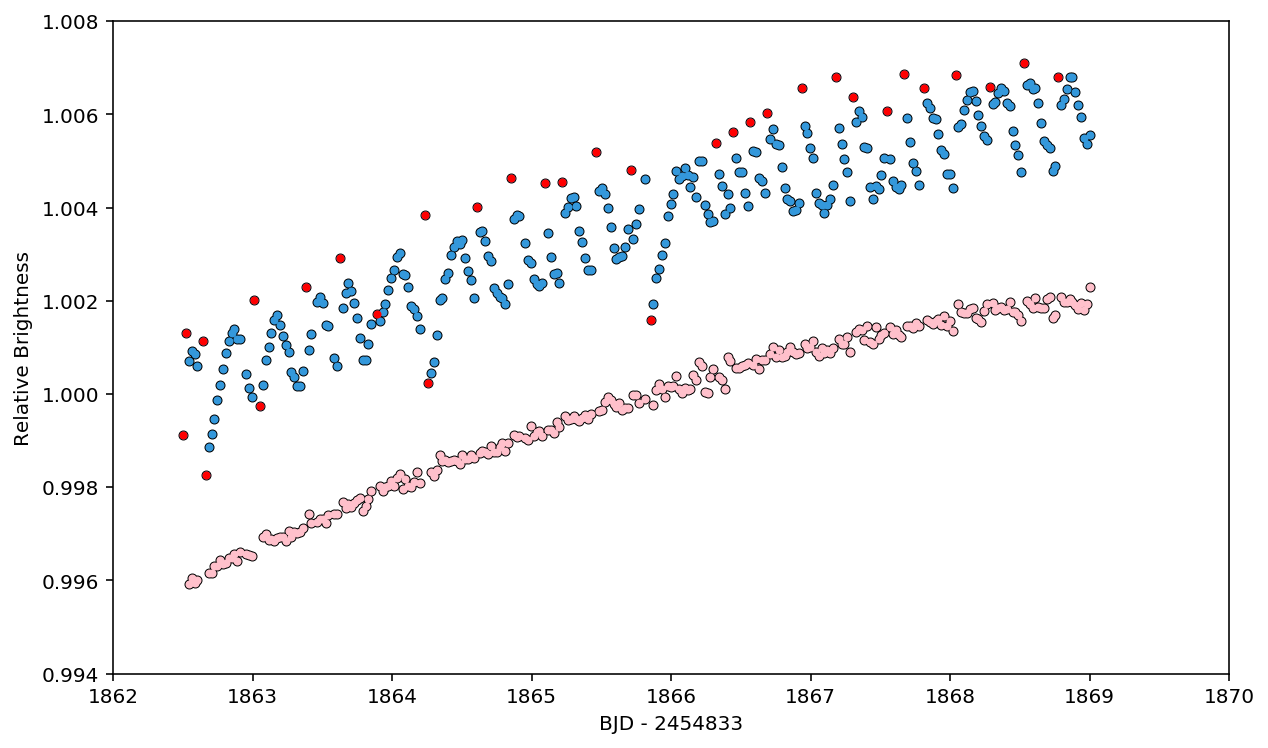

In [51]:
plt.figure(figsize=(10,6))

dy = 0.004
plt.plot(df['BJD - 2454833'], df[' Raw Flux']+dy, 'ko', ms=4)
plt.plot(df['BJD - 2454833'], df[' Raw Flux']+dy, 'o', color='#3498db', ms=3)
plt.plot(df['BJD - 2454833'][bi], df[' Raw Flux'][bi]+dy, 'o', color='r', ms=3)



plt.plot(df['BJD - 2454833'][gi], flux_corrected*bspl(tt[gi]), 'o', color='k', ms = 4)
plt.plot(df['BJD - 2454833'][gi], flux_corrected*bspl(tt[gi]), 'o', color='pink', ms = 3)
#plt.plot(df['BJD - 2454833'][gi], corr_flux*bspl(tt[gi]), 'o', color='#e67e22', ms = 3)
#plt.plot(df['BJD - 2454833'][gi], df[' Corrected Flux'][gi], 'o', color='#00ff00', ms = 4)





#plt.plot(df['BJD - 2454833'][gi], df[' Corrected Flux'][gi], 'o', color='#00ff00', ms = 4)

plt.xlabel('BJD - 2454833')
plt.ylabel('Relative Brightness')

plt.xlim(1862, 1870)
plt.ylim(0.994, 1.008);

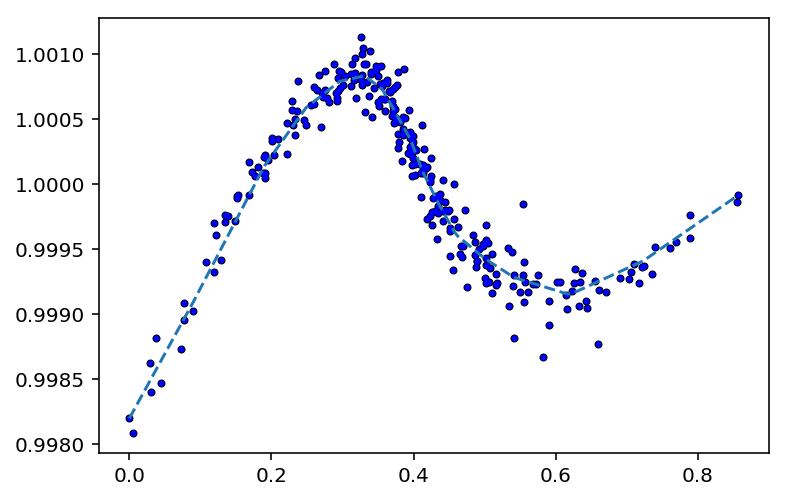

In [43]:
sff.plot_normflux_arclength()

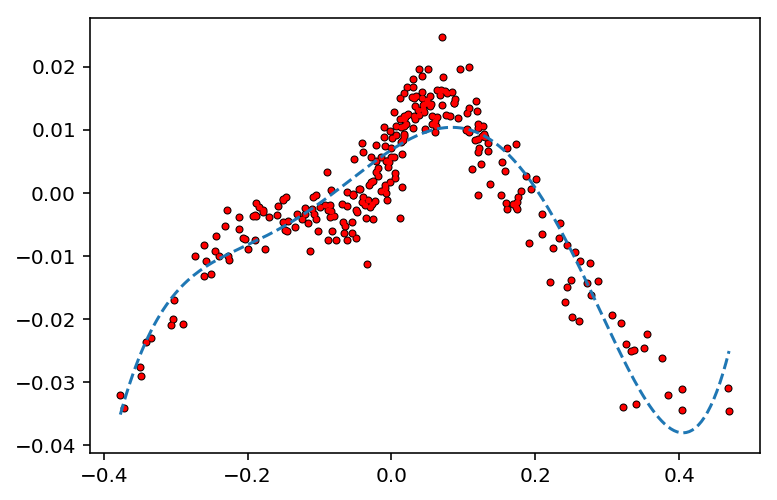

In [45]:
sff.plot_rotated_centroids()

SHAZAM!!